In [34]:
!nvidia-smi -L

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

GPU 0: Tesla T4 (UUID: GPU-5068dadc-a05e-6bdd-d015-4488193ca902)
Sat Jan  6 09:09:06 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   76C    P0              32W /  70W |   8315MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+--

In [35]:
import sys
print( f"Python {sys.version}\n" )

import os

import numpy as np
print( f"NumPy {np.__version__}\n" )

import pandas as pd
print( f"Pandas {pd.__version__}\n" )

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
print( f"Matplotlib {matplotlib.__version__}\n" )

import tensorflow as tf
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )

from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D

# Count the number of GPUs as detected by tensorflow
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]

NumPy 1.23.5

Pandas 1.5.3

Matplotlib 3.7.1

TensorFlow 2.15.0
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 1 GPU(s):
.... GPU No. 0: Name = /physical_device:GPU:0 , Type = GPU


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!pip install opencv-python-headless
!pip install wandb -qU
!pip install python-dotenv

In [51]:
!rm -rf dataset_videos frames __MACOSX

In [52]:
!unzip "/content/drive/MyDrive/Colab Notebooks/datasets/dataset_videos.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/datasets/dataset_videos.zip
   creating: dataset_videos/
   creating: dataset_videos/ads/
  inflating: __MACOSX/dataset_videos/._ads  
   creating: dataset_videos/noads/
  inflating: __MACOSX/dataset_videos/._noads  
  inflating: dataset_videos/ads/SaveTik.co_7212578427809975595.mp4  
  inflating: __MACOSX/dataset_videos/ads/._SaveTik.co_7212578427809975595.mp4  
  inflating: dataset_videos/ads/SaveTik.co_7241141835995958530.mp4  
  inflating: __MACOSX/dataset_videos/ads/._SaveTik.co_7241141835995958530.mp4  
  inflating: dataset_videos/ads/SaveTik.co_7265508793243553067.mp4  
  inflating: __MACOSX/dataset_videos/ads/._SaveTik.co_7265508793243553067.mp4  
  inflating: dataset_videos/ads/Tar_ads_18.mp4  
  inflating: __MACOSX/dataset_videos/ads/._Tar_ads_18.mp4  
  inflating: dataset_videos/ads/Tar_ads_24.mp4  
  inflating: __MACOSX/dataset_videos/ads/._Tar_ads_24.mp4  
  inflating: dataset_videos/ads/Tar_ads_25.mp4  
  inflating: __MACOS

In [53]:
import cv2
import os

def extract_frames_from_videos(video_directory, frame_directory, skip_frames=20, max_frames=10):
    # Check if frame directory exists, if not, create it
    if not os.path.exists(frame_directory):
        os.makedirs(frame_directory)

    # Process each video
    for video_name in os.listdir(video_directory):
        video_path = os.path.join(video_directory, video_name)
        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        extracted_frames = 0

        while cap.isOpened() and extracted_frames < max_frames:
            ret, frame = cap.read()
            if not ret:
                break

            # Save frames at intervals
            if frame_count % skip_frames == 0:
                if not os.path.exists(f"{frame_directory}/{video_name}"):
                  os.makedirs(f"{frame_directory}/{video_name}")
                frame_path = os.path.join(f"{frame_directory}/{video_name}", f"{video_name}_frame{frame_count}.jpg")
                cv2.imwrite(frame_path, frame)
                extracted_frames += 1

            frame_count += 1

        cap.release()

# Example usage for each category
extract_frames_from_videos('/content/dataset_videos/ads', '/content/frames/ads')
extract_frames_from_videos('/content/dataset_videos/noads', '/content/frames/noads')


In [54]:
import wandb
print(f'WandB {wandb.__version__}')

WandB 0.16.1


In [55]:
# Choose how you want to use WandB

menu = f"Do you have an environment variable named 'WANDB_API_KEY' stored in .env file?\nYour answer (y/n): "
while True:
  choice = input(menu).lower().strip()

  if choice == 'y':
    # Load 'WANDB_API_KEY' from the ".env" file
    from dotenv import load_dotenv
    load_dotenv('/content/env')
    WANDB_API_KEY = os.getenv('WANDB_API_KEY')
    # print(WANDB_API_KEY)
    # Login with your WandB account
    wandb.login(key=WANDB_API_KEY)
    break

  elif choice == 'n':
    # Login as anonymous (no need for API key)
    wandb.login(anonymous='allow')
    break

  else:
    print('Invalid input. Try again.\n')

Do you have an environment variable named 'WANDB_API_KEY' stored in .env file?
Your answer (y/n): y


In [56]:
!rm -rf test_folder train_folder

In [48]:
import os
import cv2

def resize_images_in_directory(source_directory, target_directory, size=(224, 224)):
    if not os.path.exists(target_directory):
        os.makedirs(target_directory)

    for subdir, dirs, files in os.walk(source_directory):
        for file in files:
            file_path = os.path.join(subdir, file)
            img = cv2.imread(file_path)
            if img is not None:
                # Resize the image
                resized_img = cv2.resize(img, size)

                # Save the resized image to the target directory
                target_file_path = os.path.join(target_directory, file)
                cv2.imwrite(target_file_path, resized_img)
            else:
                print(f"Unable to read file: {file_path}")

# Example usage
source_dir = '/content/frames'
target_dir = '/content/resize_frames'
resize_images_in_directory(source_dir, target_dir)

In [57]:
import os
import random
import shutil

# Define the root directory where your data is located
root_dir = '/content/frames'

# Define the destination directories for train and test data
train_dir = '/content/train_folder'
test_dir = '/content/test_folder'

# Define the labels (classes)
labels = ['noads', 'ads']

# Create train and test directories if they don't exist
if not os.path.exists(train_dir):
    os.makedirs(train_dir)

if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Define the test split ratio (0.2 for 20%)
test_split = 0.2

# Initialize lists to store file paths and labels
X_train = []
X_test = []
Y_train = []
Y_test = []

# Loop through each label (class)
for label in labels:
    label_dir = os.path.join(root_dir, label)

    # List all files in the current label directory
    all_files = [f for f in os.listdir(label_dir)]

    # Calculate the number of files to move to the test set
    num_files_test = int(len(all_files) * test_split)

    # Randomly shuffle the list of all files
    random.shuffle(all_files)

    # Split the list into train and test files
    test_files = all_files[:num_files_test]
    train_files = all_files[num_files_test:]


    # Move the test files to the test directory and record their paths and labels
    for test_file in test_files:
        src = os.path.join(label_dir, test_file)
        dst = os.path.join(test_dir, label, test_file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)

    # Move the train files to the train directory and record their paths and labels
    for train_file in train_files:
        src = os.path.join(label_dir, train_file)
        dst = os.path.join(train_dir, label, train_file)
        os.makedirs(os.path.dirname(dst), exist_ok=True)
        shutil.move(src, dst)


print("Data split into train and test sets with a 0.2 (20%) test split.")


Data split into train and test sets with a 0.2 (20%) test split.


In [58]:

from sklearn.model_selection import train_test_split

def load_images_from_folder(folder):
    images = []
    labels = []
    for filename in os.listdir(folder):
        if filename == 'noads': label = 0
        if filename == 'ads': label = 1
        for imageFileFolder in os.listdir(f"{folder}/{filename}"):
          for imageFileName in os.listdir(f"{folder}/{filename}/{imageFileFolder}"):
            img = cv2.imread(os.path.join(f"{folder}{filename}", imageFileFolder,imageFileName))
            # print(os.path.join(f"{folder}{filename}", imageFileFolder,imageFileName))
            if img is not None:
                img = cv2.resize(img, (224, 224))  # Resize to the size required by your model
                images.append(img)
                labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load images from each class
X_train, Y_train = load_images_from_folder('/content/train_folder/')
X_test, Y_test = load_images_from_folder('/content/test_folder/')



# # Combine and convert to numpy arrays
# X = np.array(ads_images + noads_images)
# Y = np.array(ads_labels + noads_labels)

# # Split into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# Now, X_train and Y_train can be used for training with augmentation


In [59]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(1629, 224, 224, 3)
(1629,)
(400, 224, 224, 3)
(400,)


In [61]:
print( f"x_train: type={type(X_train)} , dtype={X_train.dtype} , shape={X_train.shape} , min={X_train.min(axis=None)} , max={X_train.max(axis=None)}" )
print( f"y_train: type={type(Y_train)} , dtype={Y_train.dtype} , shape={Y_train.shape} , min={min(Y_train)} , max={max(Y_train)}" )
print( f"x_test: type={type(X_test)} , dtype={X_test.dtype} , shape={X_test.shape} , min={X_test.min(axis=None)} , max={X_test.max(axis=None)}"  )
print( f"y_test: type={type(Y_test)} , dtype={Y_test.dtype} , shape={Y_test.shape} , min={min(Y_test)} , max={max(Y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(1629, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(1629,) , min=0 , max=1
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(400, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=int64 , shape=(400,) , min=0 , max=1


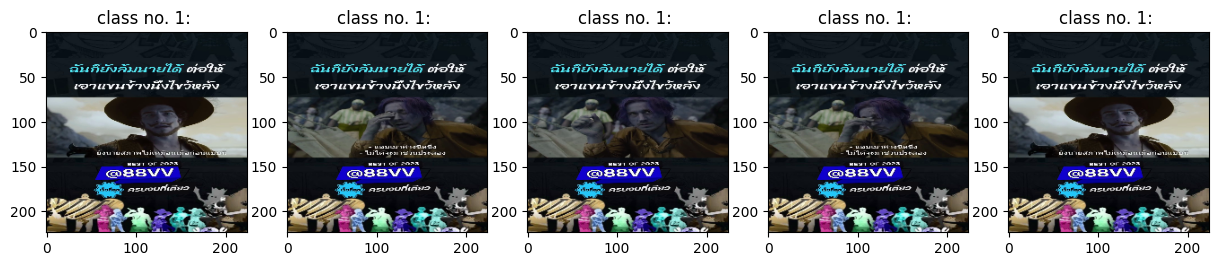

In [62]:
plt.figure(figsize=(15,5))
for i in range(5):
    plt.subplot(150 + 1 + i).set_title( f"class no. {Y_train[i]}: " )
    plt.imshow( X_train[i] )
    #plt.axis( "off" )
plt.show()

In [63]:
img_w,img_h = 224, 224
resNet101_extractor = ResNet101(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
resNet101_extractor.summary()


Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                      

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.879486 to fit



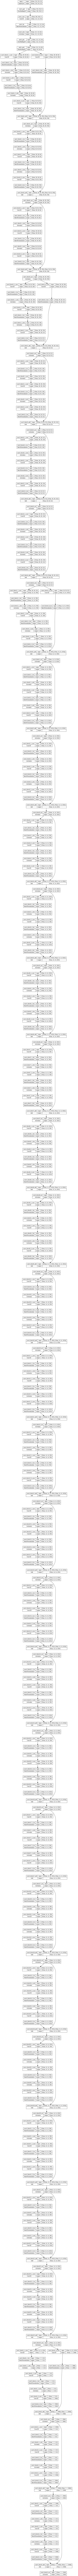

In [64]:
from tensorflow.keras.utils import plot_model
plot_model(resNet101_extractor, 'ResNet101_Model.png', show_shapes=True,show_layer_names=True)

In [65]:
#Recursively freeze all layers in the model first
resNet101_extractor.trainable = False

for i, layer in enumerate(resNet101_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_2, Trainable = False
Layer 1: Name = conv1_pad, Trainable = False
Layer 2: Name = conv1_conv, Trainable = False
Layer 3: Name = conv1_bn, Trainable = False
Layer 4: Name = conv1_relu, Trainable = False
Layer 5: Name = pool1_pad, Trainable = False
Layer 6: Name = pool1_pool, Trainable = False
Layer 7: Name = conv2_block1_1_conv, Trainable = False
Layer 8: Name = conv2_block1_1_bn, Trainable = False
Layer 9: Name = conv2_block1_1_relu, Trainable = False
Layer 10: Name = conv2_block1_2_conv, Trainable = False
Layer 11: Name = conv2_block1_2_bn, Trainable = False
Layer 12: Name = conv2_block1_2_relu, Trainable = False
Layer 13: Name = conv2_block1_0_conv, Trainable = False
Layer 14: Name = conv2_block1_3_conv, Trainable = False
Layer 15: Name = conv2_block1_0_bn, Trainable = False
Layer 16: Name = conv2_block1_3_bn, Trainable = False
Layer 17: Name = conv2_block1_add, Trainable = False
Layer 18: Name = conv2_block1_out, Trainable = False
Layer 19: Name = conv2_block2_

In [66]:
#Iterate over all layers in the model
for i, layer in enumerate(resNet101_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_2, Trainable = False
Layer 1: Name = conv1_pad, Trainable = False
Layer 2: Name = conv1_conv, Trainable = False
Layer 3: Name = conv1_bn, Trainable = False
Layer 4: Name = conv1_relu, Trainable = False
Layer 5: Name = pool1_pad, Trainable = False
Layer 6: Name = pool1_pool, Trainable = False
Layer 7: Name = conv2_block1_1_conv, Trainable = False
Layer 8: Name = conv2_block1_1_bn, Trainable = False
Layer 9: Name = conv2_block1_1_relu, Trainable = False
Layer 10: Name = conv2_block1_2_conv, Trainable = False
Layer 11: Name = conv2_block1_2_bn, Trainable = False
Layer 12: Name = conv2_block1_2_relu, Trainable = False
Layer 13: Name = conv2_block1_0_conv, Trainable = False
Layer 14: Name = conv2_block1_3_conv, Trainable = False
Layer 15: Name = conv2_block1_0_bn, Trainable = False
Layer 16: Name = conv2_block1_3_bn, Trainable = False
Layer 17: Name = conv2_block1_add, Trainable = False
Layer 18: Name = conv2_block1_out, Trainable = False
Layer 19: Name = conv2_block2_

In [67]:
x_train = X_train.astype('uint8')
x_test = X_test.astype('uint8')
y_train = Y_train.astype('float32')
y_test = Y_test.astype('float32')

In [68]:
print( f"x_train: type={type(x_train)} , dtype={x_train.dtype} , shape={x_train.shape} , min={x_train.min(axis=None)} , max={x_train.max(axis=None)}" )
print( f"y_train: type={type(y_train)} , dtype={y_train.dtype} , shape={y_train.shape} , min={min(y_train)} , max={max(y_train)}" )
print( f"x_test: type={type(x_test)} , dtype={x_test.dtype} , shape={x_test.shape} , min={x_test.min(axis=None)} , max={x_test.max(axis=None)}"  )
print( f"y_test: type={type(y_test)} , dtype={y_test.dtype} , shape={y_test.shape} , min={min(y_test)} , max={max(y_test)}" )

x_train: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(1629, 224, 224, 3) , min=0 , max=255
y_train: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(1629,) , min=0.0 , max=1.0
x_test: type=<class 'numpy.ndarray'> , dtype=uint8 , shape=(400, 224, 224, 3) , min=0 , max=255
y_test: type=<class 'numpy.ndarray'> , dtype=float32 , shape=(400,) , min=0.0 , max=1.0


In [69]:
#Pre-processing
x_train_resnet101 =  tf.keras.applications.resnet.preprocess_input (x_train)
x_test_resnet101 = tf.keras.applications.resnet.preprocess_input (x_test)

print(x_train_resnet101.shape)
print(x_test_resnet101.shape)

(1629, 224, 224, 3)
(400, 224, 224, 3)


In [70]:
x = resNet101_extractor.output

#Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dense(128, activation = 'relu')(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)

x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(5, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = resNet101_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.861564 to fit



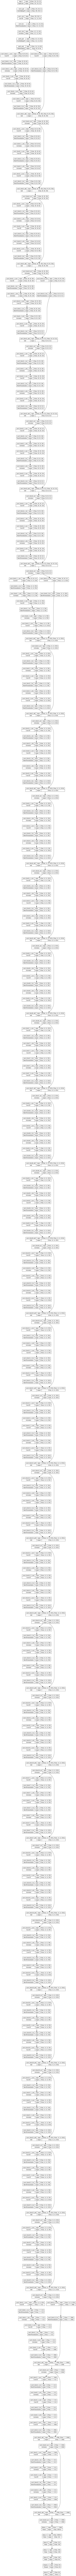

In [71]:
plot_model(model, 'Resnet101_Model_2.png', show_shapes=True,show_layer_names=True)

In [72]:
from tensorflow.keras.optimizers import Adam
from traitlets import validate

optimizer = Adam(learning_rate=0.001)

model.compile( loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"] )

In [73]:
print(y_train.shape)
print(y_train.dtype)


(1629,)
float32


In [74]:
num_classes = len(np.unique(y_train))
print(num_classes)


2


In [75]:
y_train[0:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)

In [76]:
from wandb.keras import WandbCallback
wandb.init(project='ResNet101_Image_Classification', entity='deep-a')

===== Train batch no. 1/1 =====


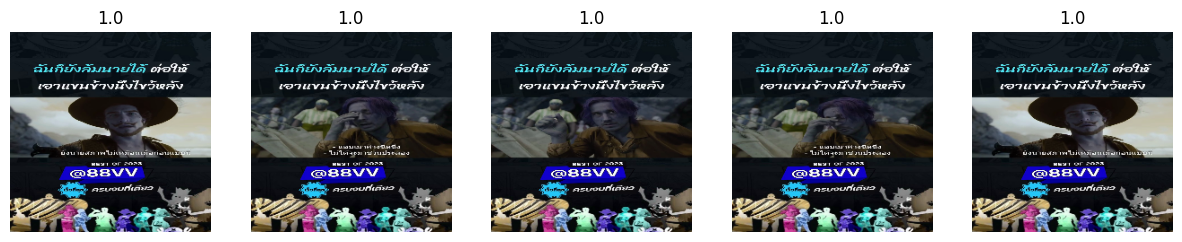

In [77]:
# n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

# for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='training' ) ):
#   print( f"===== Train batch no. {b+1}/{n_show} =====" )
#   plt.figure(figsize=(15,5))
#   for i in range(5):
#       plt.subplot(150 + 1 + i).set_title( y_batch[i] )
#       plt.imshow( x_batch[i])
#       plt.axis( "off" )        # remove all tick marks
#   plt.show()

#   if b+1 >= n_show:
#     break

n_show = 1  # Show 'n_show' batches of generated data (1 batch includes 5 images)
batch_size = 5

# Iterate through the training data manually
for b in range(n_show):
    start_idx = b * batch_size
    end_idx = (b + 1) * batch_size
    x_batch = x_train[start_idx:end_idx]
    y_batch = y_train[start_idx:end_idx]

    print(f"===== Train batch no. {b + 1}/{n_show} =====")
    plt.figure(figsize=(15, 5))

    for i in range(batch_size):
        plt.subplot(150 + 1 + i).set_title(y_batch[i])
        plt.imshow(x_batch[i])
        plt.axis("off")  # remove all tick marks

    plt.show()


In [78]:
# history = model.fit(train_datagen.flow(x_train_vgg ,y_train,batch_size=32,subset='training'),epochs = 20, verbose = 1,
#                     validation_data=train_datagen.flow(x_train_vgg ,y_train,batch_size=32,subset='validation'),
#                     callbacks=[WandbCallback()])

history = model.fit(x=x_train_resnet101, y=y_train, batch_size=32, epochs=20, verbose=1,
                    validation_split=0.2, callbacks=[WandbCallback()])


Epoch 1/20
41/41 [==============================] - ETA: 0s - loss: 3.9239 - accuracy: 0.7130

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20240106_091847-btqemkm3/files/model-best)... Done. 8.0s


41/41 [==============================] - 85s 2s/step - loss: 3.9239 - accuracy: 0.7130 - val_loss: 0.6578 - val_accuracy: 0.7454
Epoch 2/20
41/41 [==============================] - 9s 220ms/step - loss: 0.3656 - accuracy: 0.9041 - val_loss: 2.0768 - val_accuracy: 0.4356
Epoch 3/20
41/41 [==============================] - 9s 228ms/step - loss: 0.1207 - accuracy: 0.9532 - val_loss: 4.2465 - val_accuracy: 0.5399
Epoch 4/20
41/41 [==============================] - 10s 233ms/step - loss: 0.1373 - accuracy: 0.9716 - val_loss: 3.1809 - val_accuracy: 0.7761
Epoch 5/20
41/41 [==============================] - 10s 246ms/step - loss: 0.0859 - accuracy: 0.9777 - val_loss: 7.9810 - val_accuracy: 0.5184
Epoch 6/20
41/41 [==============================] - 10s 255ms/step - loss: 0.0678 - accuracy: 0.9816 - val_loss: 1.9183 - val_accuracy: 0.7454
Epoch 7/20
41/41 [==============================] - 9s 222ms/step - loss: 0.0630 - accuracy: 0.9923 - val_loss: 1.9729 - val_accuracy: 0.8221
Epoch 8/20
41/41

In [79]:
wandb.finish()

In [80]:
# results = model.evaluate(test_datagen.flow(x_test_vgg, y_test, batch_size = 128))
# print(f'{model.metrics_names}: {results}')

results = model.evaluate(x_test_resnet101, y_test, batch_size=128)
print(f'{model.metrics_names}: {results}')

4/4 [==============================] - 3s 893ms/step - loss: 2.5266 - accuracy: 0.8450
['loss', 'accuracy']: [2.526643991470337, 0.8450000286102295]


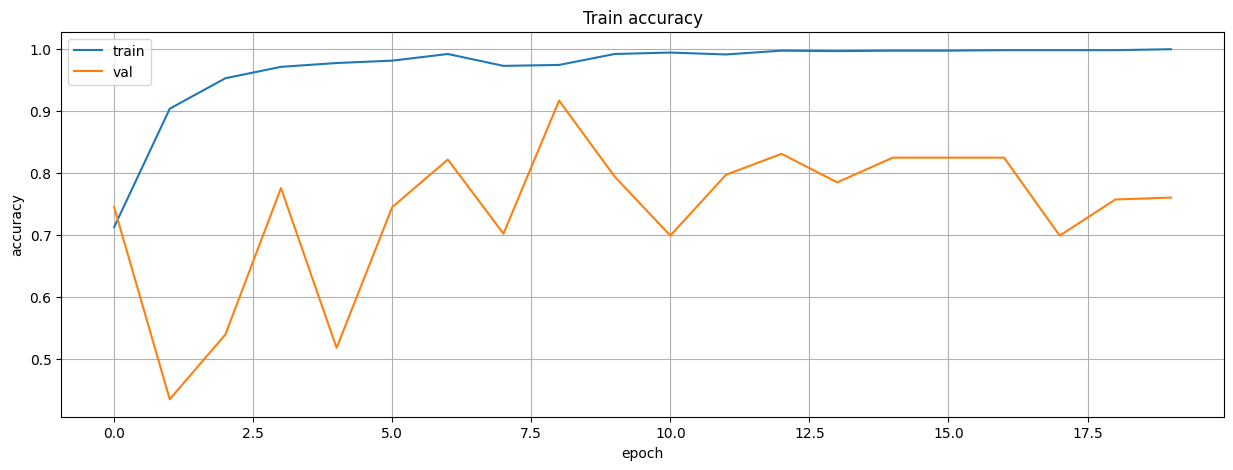

In [81]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

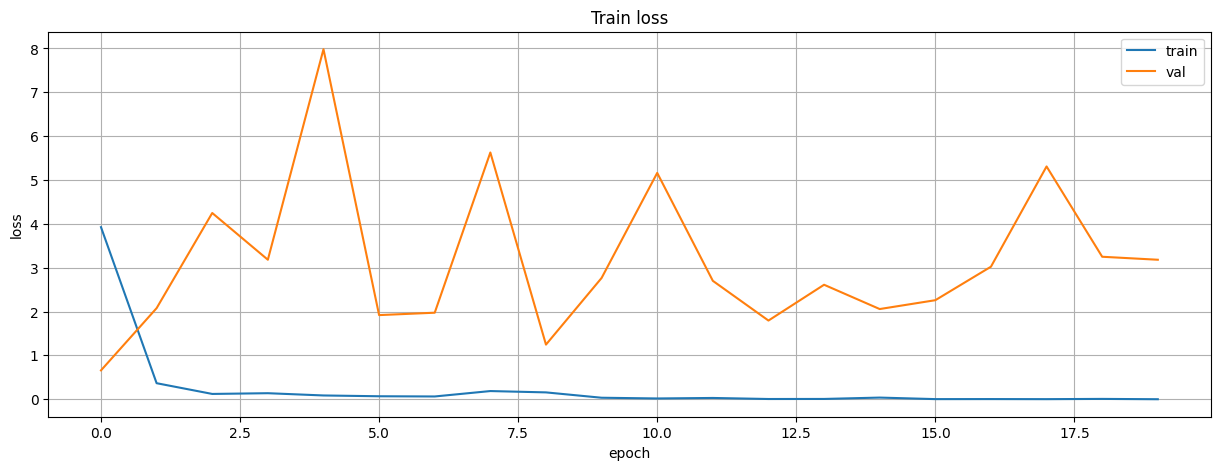

In [82]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

In [83]:
plt.rcParams["axes.linewidth"] = 5

def color_frame( ax, y_true, y_pred ):
  color = 'green' if (y_true == y_pred) else 'red'
  ax.spines['bottom'].set_color(color)
  ax.spines['top'].set_color(color)
  ax.spines['right'].set_color(color)
  ax.spines['left'].set_color(color)

samples.shape=(10, 224, 224, 3)
1/1 [==============================] - 3s 3s/step


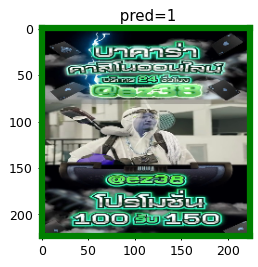

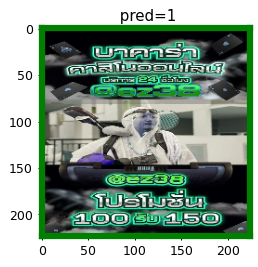

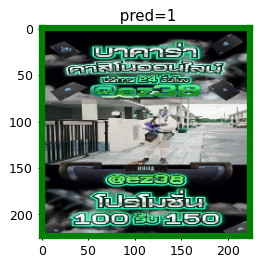

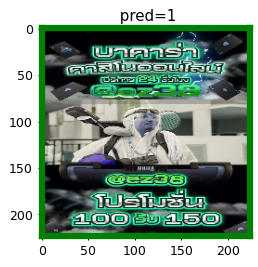

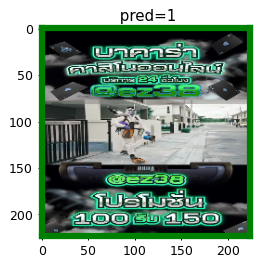

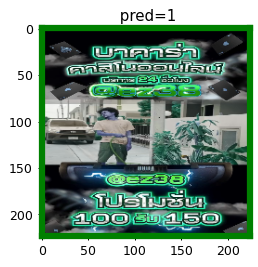

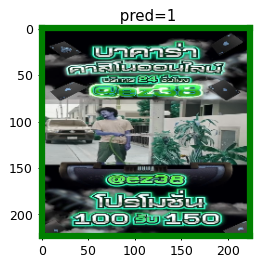

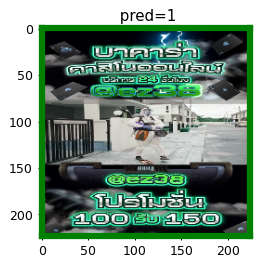

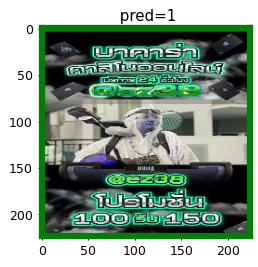

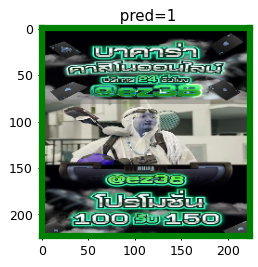

In [84]:

# Get a batch of samples
n = 10
samples = x_test[:n]
print(f'{samples.shape=}')

# Predict a batch of samples
y_pred = model.predict(samples)

# Interpret the results
for i in range(n):
  plt.figure(figsize=(3,3), dpi=90)
  ax = plt.gca()
  plt.imshow( x_test[i] )
  plt.title(f" pred={np.argmax(y_pred[i])}")
  color_frame(ax, y_test[i], np.argmax(y_pred[i]))
  plt.show()

In [85]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
y_pred1 = model.predict(X_test)
y_pred = np.argmax(y_pred1, axis=1)

print(precision_score(y_test, y_pred , average="macro"))
print(recall_score(y_test, y_pred , average="macro"))
print(f1_score(y_test, y_pred , average="macro"))

13/13 [==============================] - 2s 158ms/step
0.855
0.855
0.855


In [86]:
import keras

img_size = (224, 224)
preprocess_input = keras.applications.vgg16.preprocess_input
last_conv_layer_name = "block5_pool"

In [87]:
from IPython.display import Image, display
import matplotlib.cm as cmp


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = plt.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(20):
  c= np.random.randint(0,180)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {[(np.argmax(preds))]} | Actual: {[(y_test[c])]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)

1/1 [==============================] - 3s 3s/step
Predicted: [0] | Actual: [1.0] 


ValueError: No such layer: block5_pool. Existing layers are: ['input_2', 'conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_block1_3_bn', 'conv3_block1_add', 'conv3_block1_out', 'conv3_block2_1_conv', 'conv3_block2_1_bn', 'conv3_block2_1_relu', 'conv3_block2_2_conv', 'conv3_block2_2_bn', 'conv3_block2_2_relu', 'conv3_block2_3_conv', 'conv3_block2_3_bn', 'conv3_block2_add', 'conv3_block2_out', 'conv3_block3_1_conv', 'conv3_block3_1_bn', 'conv3_block3_1_relu', 'conv3_block3_2_conv', 'conv3_block3_2_bn', 'conv3_block3_2_relu', 'conv3_block3_3_conv', 'conv3_block3_3_bn', 'conv3_block3_add', 'conv3_block3_out', 'conv3_block4_1_conv', 'conv3_block4_1_bn', 'conv3_block4_1_relu', 'conv3_block4_2_conv', 'conv3_block4_2_bn', 'conv3_block4_2_relu', 'conv3_block4_3_conv', 'conv3_block4_3_bn', 'conv3_block4_add', 'conv3_block4_out', 'conv4_block1_1_conv', 'conv4_block1_1_bn', 'conv4_block1_1_relu', 'conv4_block1_2_conv', 'conv4_block1_2_bn', 'conv4_block1_2_relu', 'conv4_block1_0_conv', 'conv4_block1_3_conv', 'conv4_block1_0_bn', 'conv4_block1_3_bn', 'conv4_block1_add', 'conv4_block1_out', 'conv4_block2_1_conv', 'conv4_block2_1_bn', 'conv4_block2_1_relu', 'conv4_block2_2_conv', 'conv4_block2_2_bn', 'conv4_block2_2_relu', 'conv4_block2_3_conv', 'conv4_block2_3_bn', 'conv4_block2_add', 'conv4_block2_out', 'conv4_block3_1_conv', 'conv4_block3_1_bn', 'conv4_block3_1_relu', 'conv4_block3_2_conv', 'conv4_block3_2_bn', 'conv4_block3_2_relu', 'conv4_block3_3_conv', 'conv4_block3_3_bn', 'conv4_block3_add', 'conv4_block3_out', 'conv4_block4_1_conv', 'conv4_block4_1_bn', 'conv4_block4_1_relu', 'conv4_block4_2_conv', 'conv4_block4_2_bn', 'conv4_block4_2_relu', 'conv4_block4_3_conv', 'conv4_block4_3_bn', 'conv4_block4_add', 'conv4_block4_out', 'conv4_block5_1_conv', 'conv4_block5_1_bn', 'conv4_block5_1_relu', 'conv4_block5_2_conv', 'conv4_block5_2_bn', 'conv4_block5_2_relu', 'conv4_block5_3_conv', 'conv4_block5_3_bn', 'conv4_block5_add', 'conv4_block5_out', 'conv4_block6_1_conv', 'conv4_block6_1_bn', 'conv4_block6_1_relu', 'conv4_block6_2_conv', 'conv4_block6_2_bn', 'conv4_block6_2_relu', 'conv4_block6_3_conv', 'conv4_block6_3_bn', 'conv4_block6_add', 'conv4_block6_out', 'conv4_block7_1_conv', 'conv4_block7_1_bn', 'conv4_block7_1_relu', 'conv4_block7_2_conv', 'conv4_block7_2_bn', 'conv4_block7_2_relu', 'conv4_block7_3_conv', 'conv4_block7_3_bn', 'conv4_block7_add', 'conv4_block7_out', 'conv4_block8_1_conv', 'conv4_block8_1_bn', 'conv4_block8_1_relu', 'conv4_block8_2_conv', 'conv4_block8_2_bn', 'conv4_block8_2_relu', 'conv4_block8_3_conv', 'conv4_block8_3_bn', 'conv4_block8_add', 'conv4_block8_out', 'conv4_block9_1_conv', 'conv4_block9_1_bn', 'conv4_block9_1_relu', 'conv4_block9_2_conv', 'conv4_block9_2_bn', 'conv4_block9_2_relu', 'conv4_block9_3_conv', 'conv4_block9_3_bn', 'conv4_block9_add', 'conv4_block9_out', 'conv4_block10_1_conv', 'conv4_block10_1_bn', 'conv4_block10_1_relu', 'conv4_block10_2_conv', 'conv4_block10_2_bn', 'conv4_block10_2_relu', 'conv4_block10_3_conv', 'conv4_block10_3_bn', 'conv4_block10_add', 'conv4_block10_out', 'conv4_block11_1_conv', 'conv4_block11_1_bn', 'conv4_block11_1_relu', 'conv4_block11_2_conv', 'conv4_block11_2_bn', 'conv4_block11_2_relu', 'conv4_block11_3_conv', 'conv4_block11_3_bn', 'conv4_block11_add', 'conv4_block11_out', 'conv4_block12_1_conv', 'conv4_block12_1_bn', 'conv4_block12_1_relu', 'conv4_block12_2_conv', 'conv4_block12_2_bn', 'conv4_block12_2_relu', 'conv4_block12_3_conv', 'conv4_block12_3_bn', 'conv4_block12_add', 'conv4_block12_out', 'conv4_block13_1_conv', 'conv4_block13_1_bn', 'conv4_block13_1_relu', 'conv4_block13_2_conv', 'conv4_block13_2_bn', 'conv4_block13_2_relu', 'conv4_block13_3_conv', 'conv4_block13_3_bn', 'conv4_block13_add', 'conv4_block13_out', 'conv4_block14_1_conv', 'conv4_block14_1_bn', 'conv4_block14_1_relu', 'conv4_block14_2_conv', 'conv4_block14_2_bn', 'conv4_block14_2_relu', 'conv4_block14_3_conv', 'conv4_block14_3_bn', 'conv4_block14_add', 'conv4_block14_out', 'conv4_block15_1_conv', 'conv4_block15_1_bn', 'conv4_block15_1_relu', 'conv4_block15_2_conv', 'conv4_block15_2_bn', 'conv4_block15_2_relu', 'conv4_block15_3_conv', 'conv4_block15_3_bn', 'conv4_block15_add', 'conv4_block15_out', 'conv4_block16_1_conv', 'conv4_block16_1_bn', 'conv4_block16_1_relu', 'conv4_block16_2_conv', 'conv4_block16_2_bn', 'conv4_block16_2_relu', 'conv4_block16_3_conv', 'conv4_block16_3_bn', 'conv4_block16_add', 'conv4_block16_out', 'conv4_block17_1_conv', 'conv4_block17_1_bn', 'conv4_block17_1_relu', 'conv4_block17_2_conv', 'conv4_block17_2_bn', 'conv4_block17_2_relu', 'conv4_block17_3_conv', 'conv4_block17_3_bn', 'conv4_block17_add', 'conv4_block17_out', 'conv4_block18_1_conv', 'conv4_block18_1_bn', 'conv4_block18_1_relu', 'conv4_block18_2_conv', 'conv4_block18_2_bn', 'conv4_block18_2_relu', 'conv4_block18_3_conv', 'conv4_block18_3_bn', 'conv4_block18_add', 'conv4_block18_out', 'conv4_block19_1_conv', 'conv4_block19_1_bn', 'conv4_block19_1_relu', 'conv4_block19_2_conv', 'conv4_block19_2_bn', 'conv4_block19_2_relu', 'conv4_block19_3_conv', 'conv4_block19_3_bn', 'conv4_block19_add', 'conv4_block19_out', 'conv4_block20_1_conv', 'conv4_block20_1_bn', 'conv4_block20_1_relu', 'conv4_block20_2_conv', 'conv4_block20_2_bn', 'conv4_block20_2_relu', 'conv4_block20_3_conv', 'conv4_block20_3_bn', 'conv4_block20_add', 'conv4_block20_out', 'conv4_block21_1_conv', 'conv4_block21_1_bn', 'conv4_block21_1_relu', 'conv4_block21_2_conv', 'conv4_block21_2_bn', 'conv4_block21_2_relu', 'conv4_block21_3_conv', 'conv4_block21_3_bn', 'conv4_block21_add', 'conv4_block21_out', 'conv4_block22_1_conv', 'conv4_block22_1_bn', 'conv4_block22_1_relu', 'conv4_block22_2_conv', 'conv4_block22_2_bn', 'conv4_block22_2_relu', 'conv4_block22_3_conv', 'conv4_block22_3_bn', 'conv4_block22_add', 'conv4_block22_out', 'conv4_block23_1_conv', 'conv4_block23_1_bn', 'conv4_block23_1_relu', 'conv4_block23_2_conv', 'conv4_block23_2_bn', 'conv4_block23_2_relu', 'conv4_block23_3_conv', 'conv4_block23_3_bn', 'conv4_block23_add', 'conv4_block23_out', 'conv5_block1_1_conv', 'conv5_block1_1_bn', 'conv5_block1_1_relu', 'conv5_block1_2_conv', 'conv5_block1_2_bn', 'conv5_block1_2_relu', 'conv5_block1_0_conv', 'conv5_block1_3_conv', 'conv5_block1_0_bn', 'conv5_block1_3_bn', 'conv5_block1_add', 'conv5_block1_out', 'conv5_block2_1_conv', 'conv5_block2_1_bn', 'conv5_block2_1_relu', 'conv5_block2_2_conv', 'conv5_block2_2_bn', 'conv5_block2_2_relu', 'conv5_block2_3_conv', 'conv5_block2_3_bn', 'conv5_block2_add', 'conv5_block2_out', 'conv5_block3_1_conv', 'conv5_block3_1_bn', 'conv5_block3_1_relu', 'conv5_block3_2_conv', 'conv5_block3_2_bn', 'conv5_block3_2_relu', 'conv5_block3_3_conv', 'conv5_block3_3_bn', 'conv5_block3_add', 'conv5_block3_out', 'flatten_1', 'dense_5', 'dense_6', 'dense_7', 'dense_8', 'dropout_1', 'dense_9'].